# <a id='toc1_'></a>[分析](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

from MLBDataFetcher import MLBDataFetcher
from preprocess import Att_Analysis

from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.formula.api import ols

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <a id='toc1_1_'></a>[基礎分析](#toc0_)

### <a id='toc1_1_1_'></a>[ファイルの読み込み](#toc0_)

観客者数がNaNになっていたり、同じ試合が重複しているものを削除して調整。  
・NaNになる理由  
---・試合が中止になった  
---・中止になった試合の移行試合が、翌日にダブルヘッダーの1試合目として行われた場合。なぜかは不明
---・翌日以外のダブルヘッダーや、単独で試合が行われた場合はNaNにならない
・重複している理由  
---・NaNになっていても、acquire_data.ipynbで観客者数を補完するとき、gameIDに対応する観客者数を入れているため、試合が順延になると同じgameIDの試合が生まれ、両方に観客者数を入れるため  

# <a id='toc2_'></a>[Att_Analysisの使い方](#toc0_)

## <a id='toc2_1_'></a>[観客者数を取得](#toc0_)
・is_remove_covid, is_addupのオプションと共にインスタンス化して、.get_monthly_all_df()で取得

In [8]:
att_analysis = Att_Analysis(is_remove_covid=True, is_addup=True, how_completion_outlier = 'with_median')
att_analysis.get_monthly_all_df()
df = att_analysis.df_monthly_att_all_addup_covid_removed
df

## 2022年4月を補完

2022年4月は中央値11222683で補完しました。


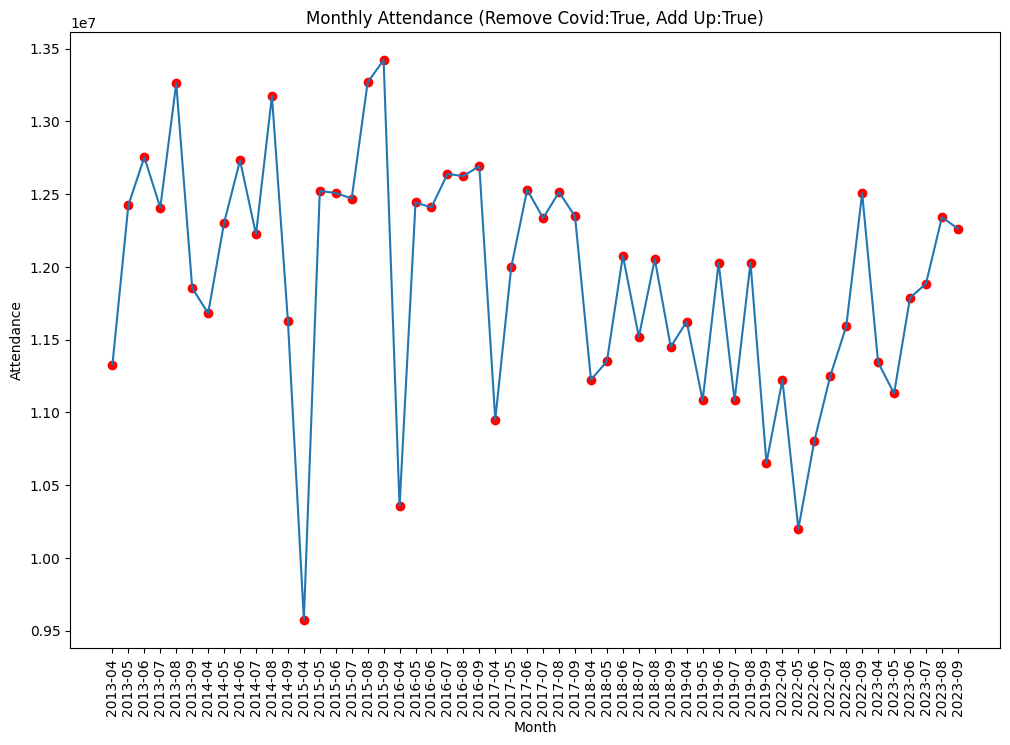

In [9]:
att_analysis.plot_monthly_att_all()

それぞれの補完方法の違いを一つの図でプロットする

In [13]:
# SARIMAX
att_analysis = Att_Analysis(is_remove_covid=True, is_addup=True, how_completion_outlier = 'with_predict')
att_analysis.get_monthly_all_df()
df_predict = att_analysis.df_monthly_att_all_addup_covid_removed

# 平均
att_analysis = Att_Analysis(is_remove_covid=True, is_addup=True, how_completion_outlier = 'with_mean')
att_analysis.get_monthly_all_df()
df_mean = att_analysis.df_monthly_att_all_addup_covid_removed

# 中央値
att_analysis = Att_Analysis(is_remove_covid=True, is_addup=True, how_completion_outlier = 'with_median')
att_analysis.get_monthly_all_df()
df_median = att_analysis.df_monthly_att_all_addup_covid_removed

# ノーマル
att_analysis = Att_Analysis(is_remove_covid=True, is_addup=True)
att_analysis.get_monthly_all_df()
df_normal = att_analysis.df_monthly_att_all_addup_covid_removed

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29988D+01    |proj g|=  2.06281D+00

At iterate    5    f=  1.23400D+01    |proj g|=  1.28532D-01

At iterate   10    f=  1.22608D+01    |proj g|=  9.35530D-02

At iterate   15    f=  1.22243D+01    |proj g|=  1.57222D-01

At iterate   20    f=  1.22021D+01    |proj g|=  1.08947D-01

At iterate   25    f=  1.22013D+01    |proj g|=  6.39626D-03

At iterate   30    f=  1.22006D+01    |proj g|=  1.02883D-01

At iterate   35    f=  1.21992D+01    |proj g|=  2.35841D-02

At iterate   40    f=  1.21986D+01    |proj g|=  7.89498D-03

At iterate   45    f=  1.21969D+01    |proj g|=  6.38762D-03


/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.21951D+01    |proj g|=  1.73677D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   1.737D-01   1.220D+01
  F =   12.195089871467578     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
AIC:1066.7777289462117
2022年4月は予測モデルで補完しました。値:10030792
2022年4月は平均値10961359で補完しました。
2022年4月は中央値11222683で補完しました。


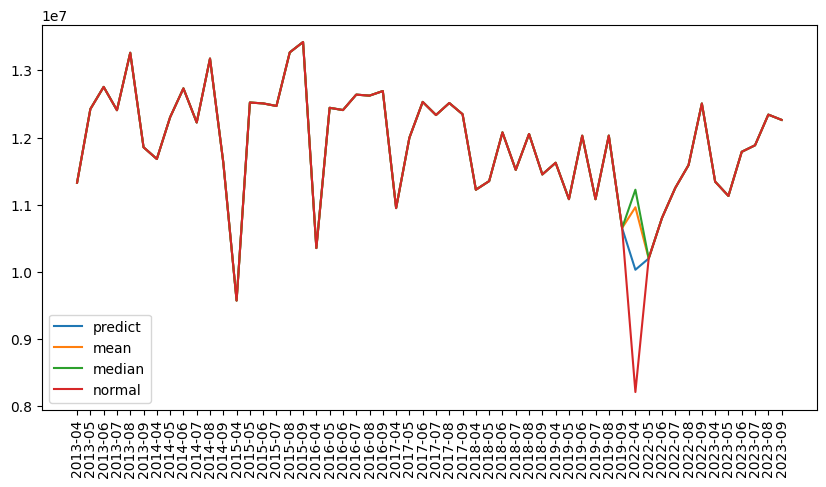

In [14]:
# df_predict, df_mean, df_medianを一つの図でプロットする
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_predict.index, df_predict['Attendance'], label='predict')
ax.plot(df_mean.index, df_mean['Attendance'], label='mean')
ax.plot(df_median.index, df_median['Attendance'], label='median')
ax.plot(df_normal.index, df_normal['Attendance'], label='normal')
plt.xticks(rotation=90)
ax.legend()
plt.show()

#! 補完したものを図示したい。SARIMAXは、過去の当てはめも含めて。

## <a id='toc2_2_'></a>[試合時間を取得](#toc0_)

In [4]:
att_analysis.get_game_time()

,Game Time (minutes)
Year,
2012,180
2013,184
2014,187
2015,180
2016,184
2017,188
2018,184
2019,190
2022,186


## <a id='toc2_3_'></a>[観客者数を月毎にプロットする](#toc0_)

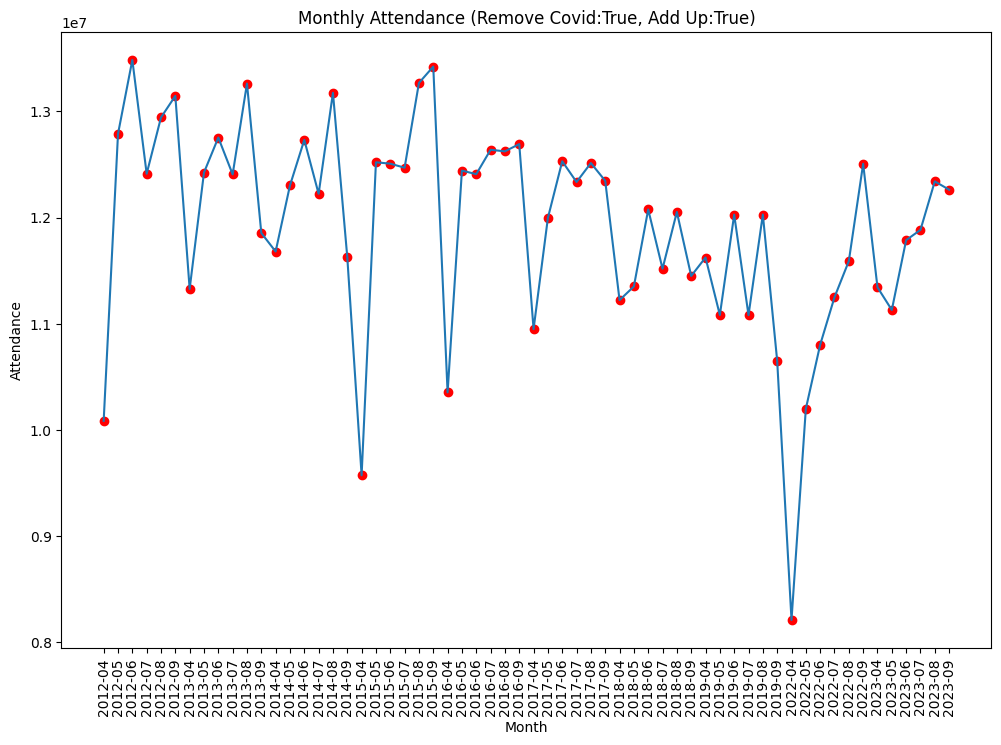

In [5]:
att_analysis.plot_monthly_att_all()

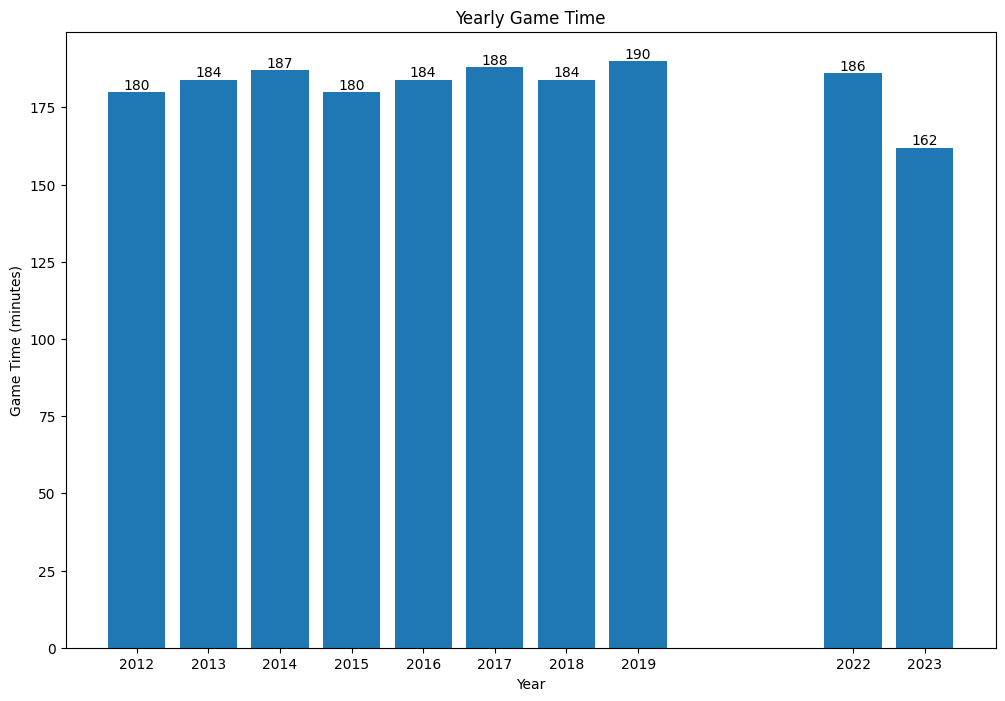

In [6]:
att_analysis.plot_game_time()

# <a id='toc3_'></a>[分析](#toc0_)

## <a id='toc3_1_'></a>[試合時間のt検定](#toc0_)

In [6]:
import numpy as np
from scipy import stats

# 年毎の平均試合時間データ
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023]
game_times = [180, 184, 187, 180, 184, 188, 184, 190, 192, 186, 162]

# 2023年のデータとそれ以前のデータに分ける
game_time_2023 = game_times[years.index(2023)]
game_times_before_2023 = [time for i, time in enumerate(game_times) if years[i] != 2023]

# 1-sample t検定を実行
t_stat, p_value = stats.ttest_1samp(game_times_before_2023, game_time_2023)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# p値が0.05より小さい場合、統計的に有意な差があると解釈
if p_value < 0.05:
    print("2023年の平均試合時間は統計的に有意に他の年に比べて短いです。")
else:
    print("2023年の平均試合時間は統計的に有意に他の年に比べて短くはありません。")


t-statistic: 18.94367482524118
p-value: 1.4644597583541207e-08
2023年の平均試合時間は統計的に有意に他の年に比べて短いです。


## <a id='toc3_2_'></a>[観客数について](#toc0_)

In [7]:
# コロナ抜いたシーズンの合計数、715728106のはず？なんか合わない。attendance_analysis.get_covid_removed_df().sum()と比較して合わない
attendance_analysis_addup = Att_Analysis(addup=True, remove_covid=False)
attendance_analysis = Att_Analysis(addup=False, remove_covid=False)

# # Cleveland GuardiansとCleveland Indiansは合算
attendance_analysis.df.loc[attendance_analysis.df['Home Team'] == 'Cleveland Indians', 'Home Team'] = 'Cleveland Guardians'
attendance_analysis.df.loc[attendance_analysis.df['Away Team'] == 'Cleveland Indians', 'Away Team'] = 'Cleveland Guardians'
attendance_analysis_addup.df.loc[attendance_analysis_addup.df['Home Team'] == 'Cleveland Indians', 'Home Team'] = 'Cleveland Guardians'
attendance_analysis_addup.df.loc[attendance_analysis_addup.df['Away Team'] == 'Cleveland Indians', 'Away Team'] = 'Cleveland Guardians'

df_addup = attendance_analysis_addup.df_monthly_att_all
df = attendance_analysis.df_monthly_att_all

TypeError: Att_Analysis.__init__() got an unexpected keyword argument 'addup'

In [9]:
# 月別の平均観客数を集計
df_addup['Month'] = pd.to_datetime(df_addup.index, format='%Y-%m').strftime('%m')
df['Month'] = pd.to_datetime(df.index, format='%Y-%m').strftime('%m')


df_addup_mean = df_addup.groupby('Month').agg({'Attendance': 'mean'})
df_addup_mean

,Attendance
Month,
04,1.000938e+07
05,1.120550e+07
06,1.190291e+07
07,1.174210e+07
08,1.231368e+07
09,1.200747e+07


In [10]:
# 各年、各月のゲーム数を集計
# 横長に表示
# 整数で表示
df_tmp = attendance_analysis.df.groupby(['Year', 'Month']).agg({'Attendance': 'count'}).unstack().fillna(0).astype(int)
# df_tmp['sum'] = df_tmp.sum(axis=1)
df_tmp

df_tmp_addup = attendance_analysis_addup.df.groupby(['Year', 'Month']).agg({'Attendance': 'count'}).unstack().fillna(0).astype(int)


<Axes: title={'center': 'Number of Games per Month'}, xlabel='Year'>

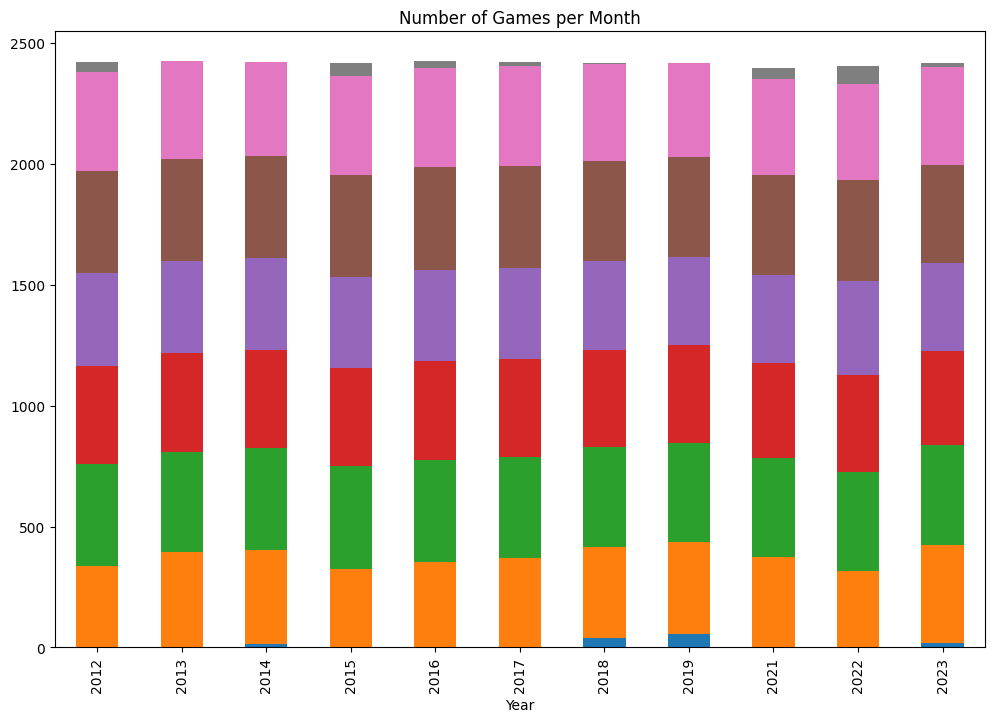

In [11]:
# 注釈は表示しない
df_tmp.plot(kind='bar', stacked=True, figsize=(12, 8), title='Number of Games per Month', legend=False)


<Axes: title={'center': 'Number of Games per Month'}, xlabel='Year'>

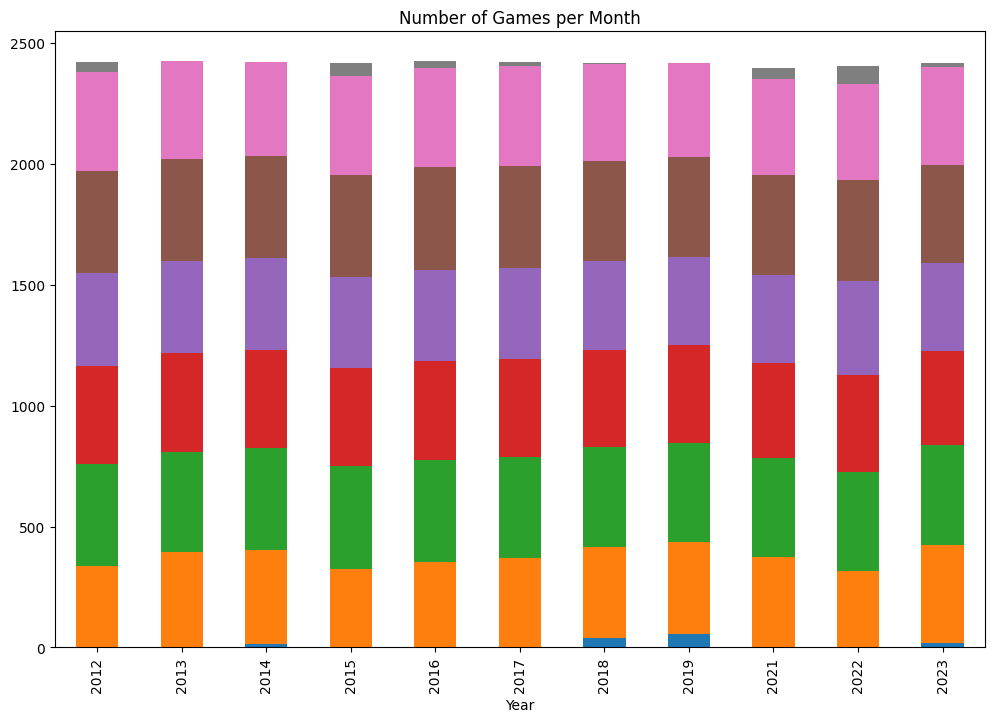

In [12]:
df_tmp_addup.plot(kind='bar', stacked=True, figsize=(12, 8), title='Number of Games per Month', legend=False)

In [13]:
# チームごとの平均観客者数を集計(ホームゲーム)
# 整数で表示


df_home_att = attendance_analysis.df.groupby('Home Team').agg({'Attendance': 'mean'}).sort_values(by='Attendance', ascending=False).astype(int)
df_away_att = attendance_analysis.df.groupby('Away Team').agg({'Attendance': 'mean'}).sort_values(by='Attendance', ascending=False).astype(int)
df_home_att

,Attendance
Home Team,
Los Angeles Dodgers,45312
St. Louis Cardinals,40599
New York Yankees,39522
San Francisco Giants,36678
Chicago Cubs,34995
Los Angeles Angels,34652
Boston Red Sox,34151
Colorado Rockies,33093
Milwaukee Brewers,31627


In [14]:
df_away_att

,Attendance
Away Team,
Los Angeles Dodgers,32553
Chicago Cubs,32027
San Francisco Giants,31650
New York Yankees,31177
San Diego Padres,30915
Pittsburgh Pirates,30578
Arizona Diamondbacks,30440
Cincinnati Reds,30026
Colorado Rockies,29971


<Axes: title={'center': 'Home Team Average Attendance'}, xlabel='Home Team'>

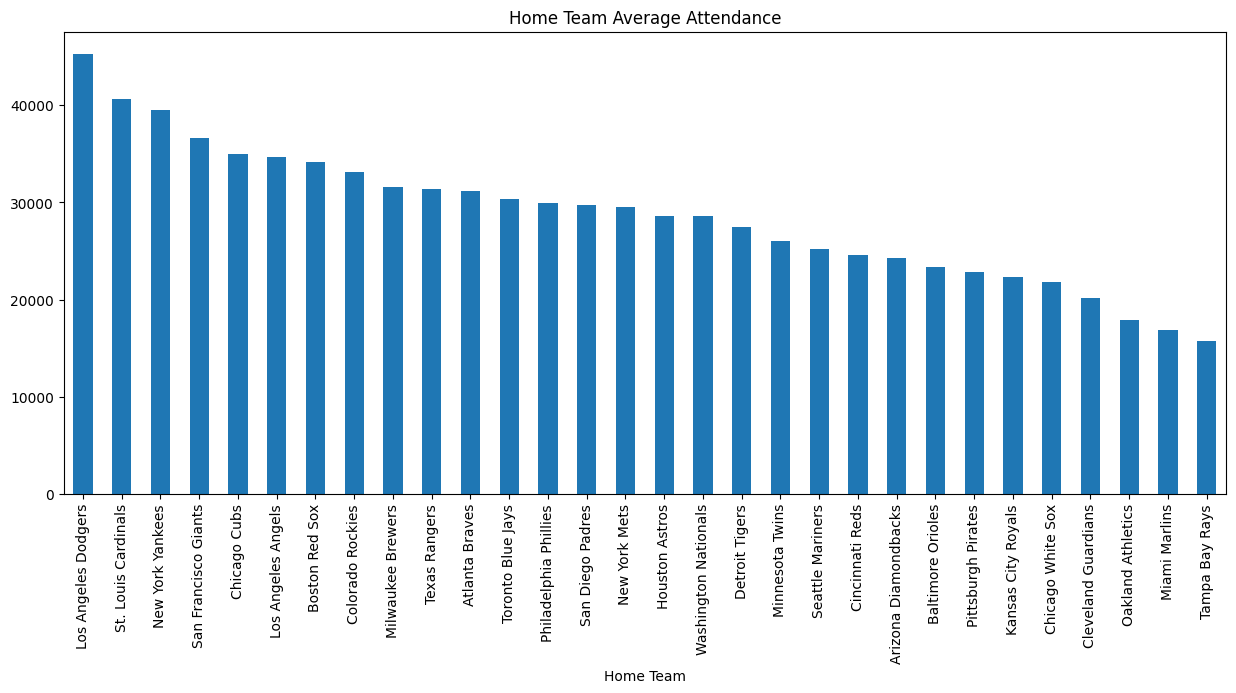

In [15]:
df_home_att.plot(kind='bar', figsize=(15, 6), title='Home Team Average Attendance', legend=False)

<Axes: title={'center': 'Home Team Average Attendance'}, xlabel='Year'>

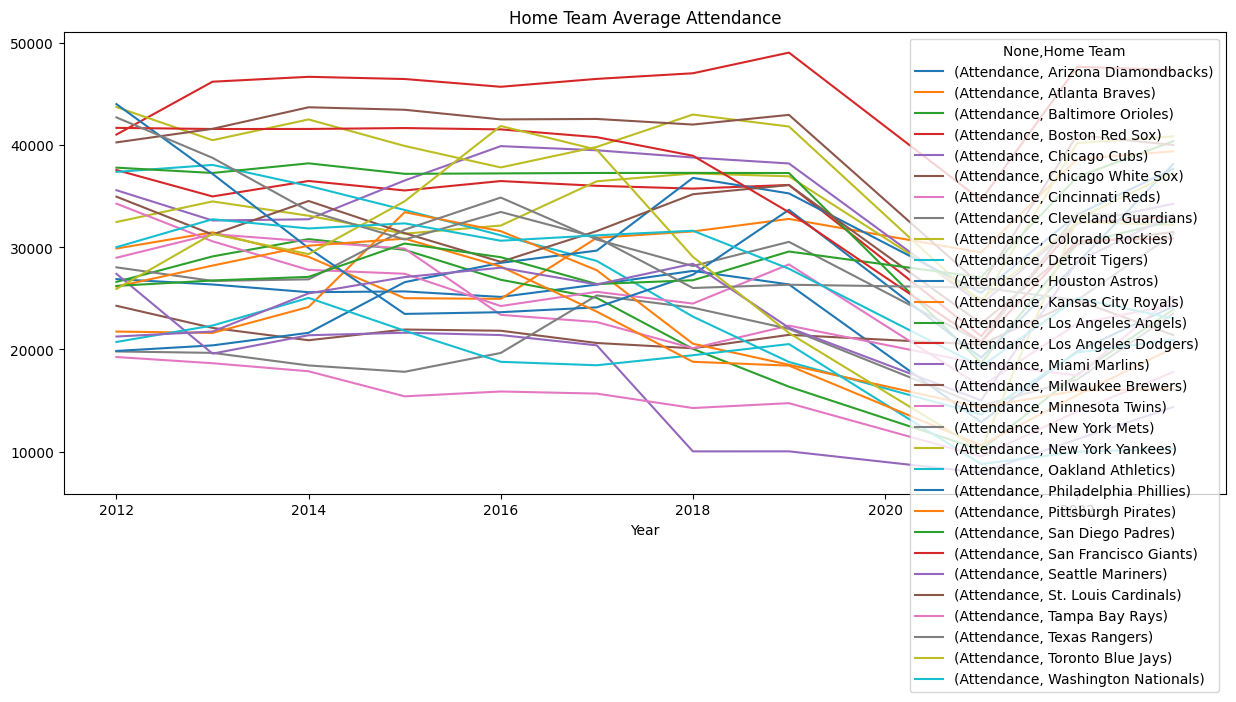

In [16]:
# チームごとの平均観客者数の推移
# 整数で表示
df_home_att_yearly = attendance_analysis.df.groupby(['Year', 'Home Team']).agg({'Attendance': 'mean'}).unstack().fillna(0).astype(int)
# 折れ線グラフ
# Cleveland GuardiansとCleveland Indiansは合算
# df_home_att_yearly['Attendance', 'Cleveland Guardians'] += df_home_att_yearly['Attendance', 'Cleveland Indians']
# df_home_att_yearly.drop(('Attendance', 'Cleveland Indians'), axis=1, inplace=True)
df_home_att_yearly

# 注釈は左に表示
df_home_att_yearly.plot(kind='line', figsize=(15, 6), title='Home Team Average Attendance', legend=True)
# df_home_att_yearly.plot(kind='line', figsize=(15, 6), title='Home Team Average Attendance', legend=False)




In [17]:
# 各球団の年毎の総観客数を集計
df_home_att_yearly_sum = attendance_analysis.df.groupby(['Year', 'Home Team']).agg({'Attendance': 'sum'}).unstack().fillna(0).astype(int)

df_home_att_yearly_sum

# 各球団の2022年までの平均合計観客者数を集計
# データフレームで表示
df_home_att_yearly_sum_mean = df_home_att_yearly_sum.iloc[:-1].mean().astype(int)
df_home_att_yearly_sum_mean = pd.DataFrame(df_home_att_yearly_sum_mean, columns=['Mean before 2022'])
# 2023年の観客者数の列を追加
df_home_att_yearly_sum_mean['2023'] = df_home_att_yearly_sum.iloc[-1]
# 2022年までの平均合計観客者数と2023年の観客者数を比較し、増減率の列を追加
# 小数第2位まで表示
df_home_att_yearly_sum_mean['Increase rate (%)'] = ((df_home_att_yearly_sum_mean['2023'] - df_home_att_yearly_sum_mean['Mean before 2022']) / df_home_att_yearly_sum_mean['Mean before 2022'] * 100).round(2)
# 増減率の列を降順にソート
df_home_att_yearly_sum_mean.sort_values(by='Increase rate (%)', ascending=False, inplace=True)

# df_home_att_yearly_sum_mean.plot(kind='bar', figsize=(15, 6), title='Home Team Average Attendance', legend=True)
df_home_att_yearly_sum_mean



Mean before 2022     2023  Increase rate (%)
           Home Team                                                          
Attendance San Diego Padres                2317979  3271554              41.14
           Seattle Mariners                1973947  2690418              36.30
           Houston Astros                  2247077  3052347              35.84
           Philadelphia Phillies           2333172  3052605              30.83
           Atlanta Braves                  2449177  3191505              30.31
           Toronto Blue Jays               2394143  3021904              26.22
           Cleveland Guardians             1571820  1834068              16.68
           Tampa Bay Rays                  1252680  1440301              14.98
           New York Mets                   2309243  2573555              11.45
           Los Angeles Dodgers             3658200  3837079               4.89
           Baltimore Orioles               1847922  1936798               4.81
           New York Yankees                3151110  3269016               3.74
           Cincinnati Reds                 1984762  2038302               2.70
           Arizona Diamondbacks            1966335  1961182              -0.26
           Milwaukee Brewers               2559668  2551347              -0.33
           Texas Rangers                   2542904  2533044              -0.39
           St. Louis Cardinals             3289290  3241091              -1.47
           Colorado Rockies                2671277  2607935              -2.37
           Chicago Cubs                    2844101  2775149              -2.42
           Boston Red Sox                  2775684  2672130              -3.73
           Chicago White Sox               1738122  1669628              -3.94
           Minnesota Twins                 2110452  1974124              -6.46
           Los Angeles Angels              2823445  2640575              -6.48
           Pittsburgh Pirates              1853229  1630624             -12.01
           Miami Marlins                   1382720  1162819             -15.90
           San Francisco Giants            3014376  2500153             -17.06
           Washington Nationals            2351068  1865832             -20.64
           Detroit Tigers                  2260671  1612876             -28.65
           Kansas City Royals              1851576  1307052             -29.41
           Oakland Athletics               1498250   832352             -44.45

In [18]:
# 2022年と2023年の観客者数をチームごとに比較
# 整数で表示
df_home_att_yearly_sum_2022_2023 = df_home_att_yearly_sum.iloc[-2:].T
df_home_att_yearly_sum_2022_2023['Increase rate (%)'] = ((df_home_att_yearly_sum_2022_2023[2023] - df_home_att_yearly_sum_2022_2023[2022]) / df_home_att_yearly_sum_2022_2023[2022] * 100).round(2)
df_home_att_yearly_sum_2022_2023['Increase number'] = df_home_att_yearly_sum_2022_2023[2023] - df_home_att_yearly_sum_2022_2023[2022]
df_home_att_yearly_sum_2022_2023.sort_values(by='Increase rate (%)', ascending=False, inplace=True)
df_home_att_yearly_sum_2022_2023


Year                                 2022     2023  Increase rate (%)   
           Home Team                                                    
Attendance Cincinnati Reds        1395770  2038302              46.03  \
           Baltimore Orioles      1368367  1936798              41.54   
           Cleveland Guardians    1295870  1834068              41.53   
           Philadelphia Phillies  2276736  3052605              34.08   
           Pittsburgh Pirates     1257458  1630624              29.68   
           Miami Marlins           907487  1162819              28.14   
           Tampa Bay Rays         1128127  1440301              27.67   
           Texas Rangers          2011361  2533044              25.94   
           Arizona Diamondbacks   1605199  1961182              22.18   
           Seattle Mariners       2287267  2690418              17.63   
           Toronto Blue Jays      2653830  3021904              13.87   
           Houston Astros         2688998  3052347              13.51   
           Minnesota Twins        1801128  1974124               9.60   
           San Diego Padres       2987470  3271554               9.51   
           Los Angeles Angels     2457461  2640575               7.45   
           Chicago Cubs           2616780  2775149               6.05   
           Oakland Athletics       787902   832352               5.64   
           Milwaukee Brewers      2422420  2551347               5.32   
           New York Yankees       3136207  3269016               4.23   
           Detroit Tigers         1575544  1612876               2.37   
           Kansas City Royals     1277686  1307052               2.30   
           Atlanta Braves         3129931  3191505               1.97   
           Boston Red Sox         2625089  2672130               1.79   
           San Francisco Giants   2482686  2500153               0.70   
           Colorado Rockies       2597428  2607935               0.40   
           New York Mets          2564737  2573555               0.34   
           Los Angeles Dodgers    3861408  3837079              -0.63   
           St. Louis Cardinals    3320551  3241091              -2.39   
           Washington Nationals   2026401  1865832              -7.92   
           Chicago White Sox      2009359  1669628             -16.91   

Year                              Increase number  
           Home Team                               
Attendance Cincinnati Reds                 642532  
           Baltimore Orioles               568431  
           Cleveland Guardians             538198  
           Philadelphia Phillies           775869  
           Pittsburgh Pirates              373166  
           Miami Marlins                   255332  
           Tampa Bay Rays                  312174  
           Texas Rangers                   521683  
           Arizona Diamondbacks            355983  
           Seattle Mariners                403151  
           Toronto Blue Jays               368074  
           Houston Astros                  363349  
           Minnesota Twins                 172996  
           San Diego Padres                284084  
           Los Angeles Angels              183114  
           Chicago Cubs                    158369  
           Oakland Athletics                44450  
           Milwaukee Brewers               128927  
           New York Yankees                132809  
           Detroit Tigers                   37332  
           Kansas City Royals               29366  
           Atlanta Braves                   61574  
           Boston Red Sox                   47041  
           San Francisco Giants             17467  
           Colorado Rockies                 10507  
           New York Mets                     8818  
           Los Angeles Dodgers             -24329  
           St. Louis Cardinals             -79460  
           Washington Nationals           -160569  
           Chicago White Sox              -339731

In [19]:
df_home_att_yearly_sum

Attendance                                    
Home Team Arizona Diamondbacks Atlanta Braves Baltimore Orioles   
Year                                                              
2012                   2177617        2420171           2102240  \
2013                   2134857        2548679           2357561   
2014                   2073730        2354305           2464473   
2015                   2080145        2001392           2320588   
2016                   2036216        2020914           2172344   
2017                   2134375        2505252           2028424   
2018                   2242695        2555781           1564192   
2019                   2135510        2655100           1307807   
2021                   1043010        2300247            793229   
2022                   1605199        3129931           1368367   
2023                   1961182        3191505           1936798   

                                                                          
Home Team Boston Red Sox Chicago Cubs Chicago White Sox Cincinnati Reds   
Year                                                                      
2012             3043003      2882756           1965955         2347251  \
2013             2833333      2642682           1768544         2534369   
2014             2956089      2652113           1650821         2476664   
2015             2880694      2959812           1755810         2419506   
2016             2955434      3232420           1746293         1894085   
2017             2917678      3199562           1629470         1836917   
2018             2895575      3181089           1608817         1629356   
2019             2924627      3094865           1649775         1808685   
2021             1725323      1978934           1596385         1505024   
2022             2625089      2616780           2009359         1395770   
2023             2672130      2775149           1669628         2038302   

                                                               ...   
Home Team Cleveland Guardians Colorado Rockies Detroit Tigers  ...   
Year                                                           ...   
2012                  1603596          2630458        3028033  ...  \
2013                  1572926          2793828        3083397  ...   
2014                  1437393          2680329        2917209  ...   
2015                  1388905          2506789        2726048  ...   
2016                  1591667          2602524        2493859  ...   
2017                  2048138          2953650        2321599  ...   
2018                  1926701          3015880        1856970  ...   
2019                  1738642          2993244        1501430  ...   
2021                  1114368          1938645        1102621  ...   
2022                  1295870          2597428        1575544  ...   
2023                  1834068          2607935        1612876  ...   

                                                                      
Home Team Philadelphia Phillies Pittsburgh Pirates San Diego Padres   
Year                                                                  
2012                    3565718            2091918          2123721  \
2013                    3012403            2256862          2166691   
2014                    2423852            2442564          2195373   
2015                    1831080            2498596          2459742   
2016                    1915144            2249201          2351422   
2017                    1905354            1919447          2138491   
2018                    2158124            1465316          2168536   
2019                    2727421            1491439          2396399   
2021                    1515890             859498          2191950   
2022                    2276736            1257458          2987470   
2023                    3052605            1630624          3271554   

                                                      

In [20]:
# 2022と2023の平均観客者数を比較
# 整数で表示
df_home_att_yearly_sum_2022_2023_mean = df_home_att_yearly_sum.iloc[-2:].astype(int).T
# df_home_att_yearly_sum_2022_2023_mean
df_home_att_yearly_sum_2022_2023_mean = (df_home_att_yearly_sum_2022_2023_mean/81).astype(int)
df_home_att_yearly_sum_2022_2023_mean['Increase rate (%)'] = ((df_home_att_yearly_sum_2022_2023_mean[2023] - df_home_att_yearly_sum_2022_2023_mean[2022]) / df_home_att_yearly_sum_2022_2023_mean[2022] * 100).round(2)
df_home_att_yearly_sum_2022_2023_mean['Increase number'] = df_home_att_yearly_sum_2022_2023_mean[2023] - df_home_att_yearly_sum_2022_2023_mean[2022]
df_home_att_yearly_sum_2022_2023_mean.sort_values(by='Increase rate (%)', ascending=False, inplace=True)
df_home_att_yearly_sum_2022_2023_mean

Year                               2022   2023  Increase rate (%)   
           Home Team                                                
Attendance Cincinnati Reds        17231  25164              46.04  \
           Baltimore Orioles      16893  23911              41.54   
           Cleveland Guardians    15998  22642              41.53   
           Philadelphia Phillies  28107  37686              34.08   
           Pittsburgh Pirates     15524  20131              29.68   
           Miami Marlins          11203  14355              28.14   
           Tampa Bay Rays         13927  17781              27.67   
           Texas Rangers          24831  31272              25.94   
           Arizona Diamondbacks   19817  24212              22.18   
           Seattle Mariners       28237  33215              17.63   
           Toronto Blue Jays      32763  37307              13.87   
           Houston Astros         33197  37683              13.51   
           Minnesota Twins        22236  24371               9.60   
           San Diego Padres       36882  40389               9.51   
           Los Angeles Angels     30339  32599               7.45   
           Chicago Cubs           32305  34261               6.05   
           Oakland Athletics       9727  10275               5.63   
           Milwaukee Brewers      29906  31498               5.32   
           New York Yankees       38718  40358               4.24   
           Detroit Tigers         19451  19912               2.37   
           Kansas City Royals     15773  16136               2.30   
           Atlanta Braves         38641  39401               1.97   
           Boston Red Sox         32408  32989               1.79   
           San Francisco Giants   30650  30866               0.70   
           Colorado Rockies       32067  32196               0.40   
           New York Mets          31663  31772               0.34   
           Los Angeles Dodgers    47671  47371              -0.63   
           St. Louis Cardinals    40994  40013              -2.39   
           Washington Nationals   25017  23034              -7.93   
           Chicago White Sox      24806  20612             -16.91   

Year                              Increase number  
           Home Team                               
Attendance Cincinnati Reds                   7933  
           Baltimore Orioles                 7018  
           Cleveland Guardians               6644  
           Philadelphia Phillies             9579  
           Pittsburgh Pirates                4607  
           Miami Marlins                     3152  
           Tampa Bay Rays                    3854  
           Texas Rangers                     6441  
           Arizona Diamondbacks              4395  
           Seattle Mariners                  4978  
           Toronto Blue Jays                 4544  
           Houston Astros                    4486  
           Minnesota Twins                   2135  
           San Diego Padres                  3507  
           Los Angeles Angels                2260  
           Chicago Cubs                      1956  
           Oakland Athletics                  548  
           Milwaukee Brewers                 1592  
           New York Yankees                  1640  
           Detroit Tigers                     461  
           Kansas City Royals                 363  
           Atlanta Braves                     760  
           Boston Red Sox                     581  
           San Francisco Giants               216  
           Colorado Rockies                   129  
           New York Mets                      109  
           Los Angeles Dodgers               -300  
           St. Louis Cardinals               -981  
           Washington Nationals             -1983  
           Chicago White Sox                -4194

In [21]:
# 2023年の導入前後のデータを分ける
df_pre_2023 = df[df['Date'] < '2023-01-01']
df_post_2023 = df[df['Date'] >= '2023-01-01']

# 同じ月のデータを取得
# 2023年のデータが完全ではない可能性があるため、2023年の存在する月だけを取得
common_months = df_post_2023['Date'].dt.month.unique()
df_pre_2023 = df_pre_2023[df_pre_2023['Date'].dt.month.isin(common_months)]

# 最新の年（2022年）のデータを取得
df_pre_2023 = df_pre_2023[df_pre_2023['Date'].dt.year == 2022]

# 導入前後の観客者数の差を計算
attendance_diff = df_post_2023['Attendance'].reset_index(drop=True) - df_pre_2023['Attendance'].reset_index(drop=True)

attendance_diff


KeyError: 'Date'

### <a id='toc3_2_1_'></a>[観客者数について、不均一分散の検定を実施](#toc0_)

In [15]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.formula.api import ols
# 月を独立変数として扱うために、月のダミー変数を作成する
# dfのindexをDateに変更
df['Date'] = pd.to_datetime(df.index, format='%Y-%m')
df['Month'] = df['Date'].dt.month

# 線形回帰モデルをフィットさせる。ここでは月ごとのダミー変数を使う
model = ols('Attendance ~ C(Month)', data=df).fit()

# ブライト・ペーガン検定を実行
test_statistic, p_value, _, _ = het_breuschpagan(model.resid, model.model.exog)
# White検定を実行
test_statistic, p_value, _, _ = het_white(model.resid, model.model.exog)


# 結果の出力
print(f"Breusch-Pagan test statistic: {test_statistic}")
print(f"p-value: {p_value}")

# 結果の出力
print(f"White test statistic: {test_statistic}")
print(f"p-value: {p_value}")

Breusch-Pagan test statistic: 5.48859211184467
p-value: 0.35919841889714993
White test statistic: 5.48859211184467
p-value: 0.35919841889714993


## <a id='toc3_3_'></a>[コロナ関連](#toc0_)

### <a id='toc3_3_1_'></a>[アメリカのコロナ感染者数を取得](#toc0_)


In [27]:
covid_new_cases_df = pd.read_csv('./data/new_cases.csv')
covid_new_deaths_df = pd.read_csv('./data/new_deaths.csv')

# covid_new_cases_dfのDateをdatetime型に変換
# フォーマットは%Y-%m
covid_new_cases_df['Date'] = pd.to_datetime(covid_new_cases_df['Date'])

# covid_new_deaths_dfのDateをdatetime型に変換
covid_new_deaths_df['Date'] = pd.to_datetime(covid_new_deaths_df['Date'])


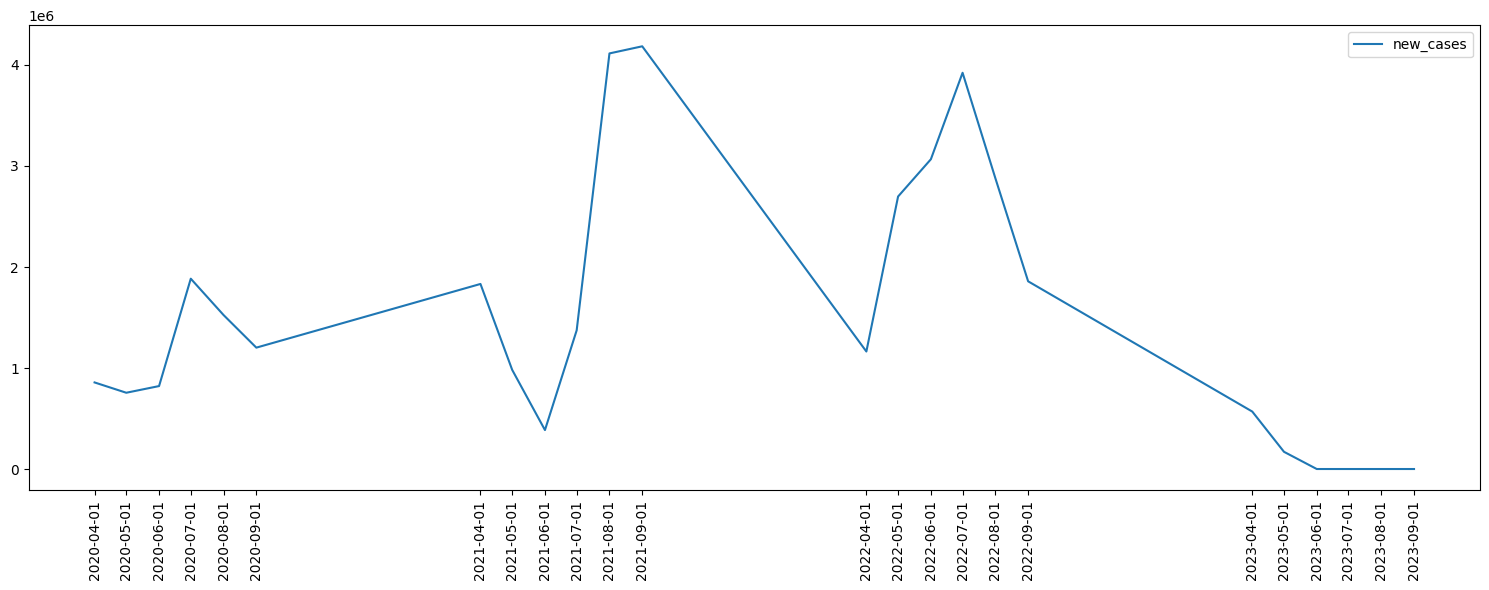

In [35]:
# covid_new-cases_dfをプロット
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(covid_new_cases_df['Date'], covid_new_cases_df['new_cases'], label='new_cases')
# plt.plot(covid_new_deaths_df['Date'], covid_new_deaths_df['new_deaths'], label='new_deaths')
# 横軸は全て表示
plt.xticks(covid_new_cases_df['Date'], rotation=90)
plt.legend()
plt.show()

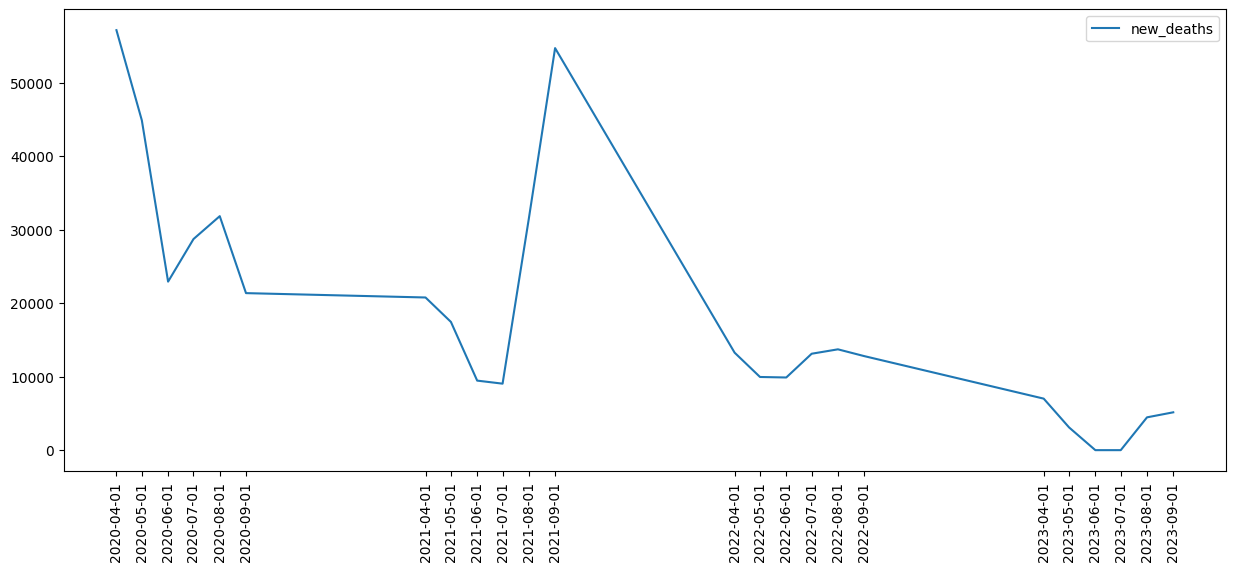

In [36]:
plt.figure(figsize=(15, 6))
plt.plot(covid_new_deaths_df['Date'], covid_new_deaths_df['new_deaths'], label='new_deaths')
plt.xticks(covid_new_deaths_df['Date'], rotation=90)
plt.legend()
plt.show()

In [56]:
# 2013年4月から2023年10月までのDate列とnew_cases列を持つデータフレームを作成
new_df = pd.DataFrame({'Date': pd.date_range('2013-04-01', '2023-09-01', freq='MS'), 'new_cases': np.nan})
# new_dfから4月から9月のデータのみに絞り込
new_df = new_df[(new_df['Date'].dt.month >= 4) & (new_df['Date'].dt.month <= 9)]
new_df.to_csv('./data/new_df.csv', index=False)

In [60]:
new_df = pd.read_csv('./data/new_df.csv')
new_df.to_csv('./data/new_deaths.csv', index=False)

In [61]:
new_cases = pd.read_csv('./data/new_deaths.csv')
new_cases

,Date,new_cases
0,2013/4/1,0
1,2013/5/1,0
2,2013/6/1,0
3,2013/7/1,0
4,2013/8/1,0
...,...,...
61,2023/5/1,3089
62,2023/6/1,0
63,2023/7/1,0
64,2023/8/1,4463


## <a id='toc3_4_'></a>[試合時間のデータを取得](#toc0_)

In [7]:
att_analysis = Att_Analysis(is_remove_covid=True, is_addup=True)
# att_analysis.add_mar_oct_to_apr_sep_game_time()
# att_analysis.df_game_time_addup
df = att_analysis.get_monthly_game_time_all()
df.to_csv('./data/monthly_average_game_time.csv', index=False)

In [4]:
df_tmp = Att_Analysis(is_remove_covid=True, is_addup=True).get_monthly_all_df()
len(df_tmp)

54

## <a id='toc3_5_'></a>[SARIMAXを適用するべきという根拠](#toc0_)

In [3]:
df = Att_Analysis(is_remove_covid=True, is_addup=True).get_monthly_all_df()
len(df)

54

In [5]:
# dfが定常かどうかを確認する
from statsmodels.tsa.stattools import adfuller  

# ADF検定を実行
# 5%有意水準で帰無仮説は棄却されない
result = adfuller(df['Attendance'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -1.2474244589943948
p-value: 0.6528696928420132
Critical Values:
   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338


In [6]:
# 1階差分を取得
df_diff = df.diff().dropna()

# ADF検定を実行
# 5%有意水準で帰無仮説は棄却される
result = adfuller(df_diff['Attendance'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -3.3378169055039266
p-value: 0.013270396110309876
Critical Values:
   1%: -3.5925042342183704
   5%: -2.931549768951162
   10%: -2.60406594375338


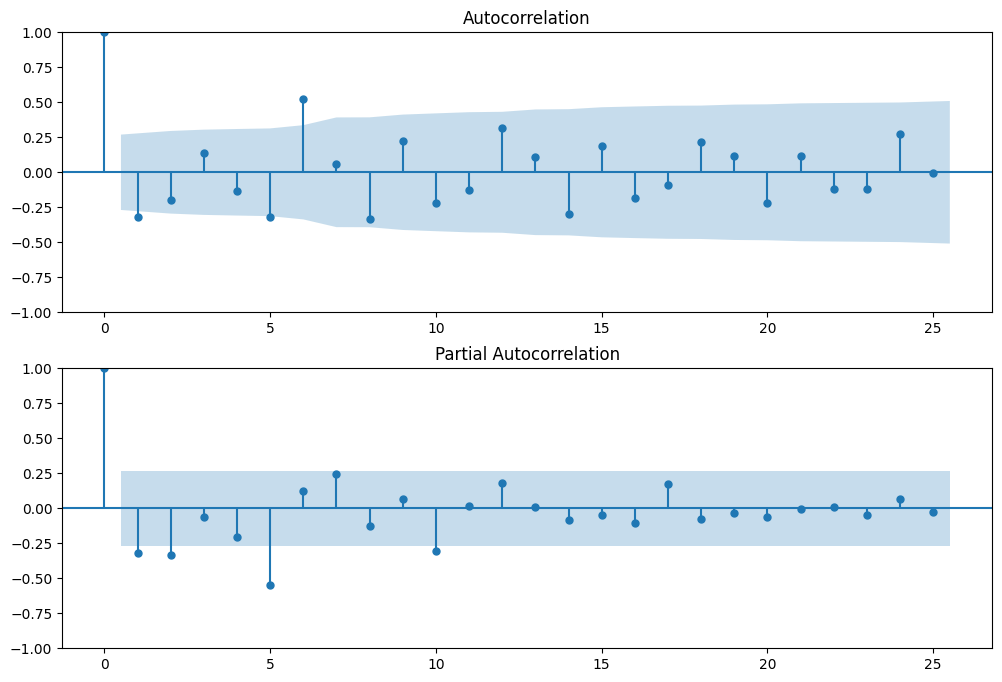

In [9]:
# 季節性があるかどうかを確認する
# ACFとPACFをプロット
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_diff['Attendance'], lags=min(40, len(df_diff['Attendance'])//2-1), ax=ax1)
# fig = plot_acf(df['Attendance'], lags=, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_diff['Attendance'], lags=min(40, len(df_diff['Attendance'])//2-1), ax=ax2)
# fig = plot_pacf(df['Attendance'], lags=1, ax=ax2)
plt.show()


## <a id='toc3_6_'></a>[コロナを説明変数に追加](#toc0_)

In [2]:
# コロナのデータを確認
covid_new_cases_df = pd.read_csv('./data/new_cases.csv')
# 年-月の形式に変換
covid_new_cases_df['Date'] = pd.to_datetime(covid_new_cases_df['Date'], format='%Y/%m/%d')

# Dateをindexに設定
covid_new_cases_df.set_index('Date', inplace=True)

# 年-月の形式に変換
# covid_new_cases_df['Date'] = pd.to_datetime(covid_new_cases_df['Date'], format='%Y-%m')

covid_new_cases_df.reset_index(inplace=True)
covid_new_cases_df

,Date,new_cases
0,2013-04-01,0
1,2013-05-01,0
2,2013-06-01,0
3,2013-07-01,0
4,2013-08-01,0
...,...,...
61,2023-05-01,170425
62,2023-06-01,0
63,2023-07-01,0
64,2023-08-01,0


In [4]:
att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True)
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()
df_ = att_remove_covid_addup.merge_new_df(covid_new_cases_df)
# att_remove_covid_addup.df_monthly_att_all_addup_covid_removed
# df_.reset_index(drop=True, inplace=True)

# # Convert the 'Date' column to year-month format
# df_['Date'] = df_['Date'].dt.strftime('%Y-%m')

# df_
df_.index.name = None
df_

,Attendance,new_cases
2013-04,11327161,0
2013-05,12423877,0
2013-06,12753480,0
2013-07,12406872,0
2013-08,13261937,0
2013-09,11854903,0
2014-04,11680152,0
2014-05,12302345,0
2014-06,12731459,0
2014-07,12223770,0


In [6]:
# df_とcovid_new_cases_dfのDateを結合
df_ = pd.merge(df_, covid_new_cases_df, on='Date', how='left')
df_

,Date,Attendance,new_cases
0,2013-04-01,11327161,0
1,2013-05-01,12423877,0
2,2013-06-01,12753480,0
3,2013-07-01,12406872,0
4,2013-08-01,13261937,0
5,2013-09-01,11854903,0
6,2014-04-01,11680152,0
7,2014-05-01,12302345,0
8,2014-06-01,12731459,0
9,2014-07-01,12223770,0
